In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct, fft2, ifft2
from scipy.ndimage import convolve
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [6]:
# ============================================================================
# 1. IMPLEMENTACIÓN BÁSICA DE JPEG CON DCT
# ============================================================================

def divide_en_bloques(imagen, tam_bloque=8):
    """Divide la imagen en bloques de 8x8 no superpuestos."""
    h, w = imagen.shape
    bloques = []
    posiciones = []
    
    for i in range(0, h, tam_bloque):
        for j in range(0, w, tam_bloque):
            bloque = imagen[i:i+tam_bloque, j:j+tam_bloque]
            # Si el bloque es más pequeño que 8x8 (bordes), lo rellenamos
            if bloque.shape != (tam_bloque, tam_bloque):
                bloque_relleno = np.zeros((tam_bloque, tam_bloque))
                bloque_relleno[:bloque.shape[0], :bloque.shape[1]] = bloque
                bloque = bloque_relleno
            bloques.append(bloque)
            posiciones.append((i, j))
    
    return bloques, posiciones

def recomponer_imagen(bloques, posiciones, shape_original, tam_bloque=8):
    """Recompone la imagen a partir de los bloques."""
    imagen_recompuesta = np.zeros(shape_original)
    h, w = shape_original
    
    for bloque, (i, j) in zip(bloques, posiciones):
        altura = min(tam_bloque, h - i)
        ancho = min(tam_bloque, w - j)
        imagen_recompuesta[i:i+altura, j:j+ancho] = bloque[:altura, :ancho]
    
    return imagen_recompuesta

def dct_2d(bloque):
    """Calcula la DCT 2D de un bloque."""
    return dct(dct(bloque.T, norm='ortho').T, norm='ortho')

def idct_2d(bloque):
    """Calcula la IDCT 2D de un bloque."""
    return idct(idct(bloque.T, norm='ortho').T, norm='ortho')

def cuantizacion_n(bloque_dct, N):
    """Cuantiza dividiendo por N, redondeando y multiplicando por N."""
    return np.round(bloque_dct / N) * N

def cuantizacion_tabla(bloque_dct, tabla_cuantizacion):
    """Cuantiza usando una tabla de cuantización."""
    return np.round(bloque_dct / tabla_cuantizacion) * tabla_cuantizacion

def cuantizacion_top_k(bloque_dct, k=8):
    """Mantiene solo los k coeficientes más grandes."""
    bloque_cuantizado = np.zeros_like(bloque_dct)
    # Aplanamos el bloque para encontrar los k valores más grandes
    bloque_flat = bloque_dct.flatten()
    indices_top = np.argsort(np.abs(bloque_flat))[-k:]
    # Solo mantenemos los k valores más grandes
    for idx in indices_top:
        i = idx // bloque_dct.shape[1]
        j = idx % bloque_dct.shape[1]
        bloque_cuantizado[i, j] = np.round(bloque_flat[idx])
    
    return bloque_cuantizado

def jpeg_dct(imagen, metodo='n', parametro=10):
    """
    Implementación básica de JPEG con DCT.
    
    Parámetros:
    - imagen: imagen de entrada (escala de grises)
    - metodo: 'n' (división por N), 'tabla' (tabla estándar), 'topk' (k coeficientes)
    - parametro: valor de N, o k, según el método
    """
    # Tabla de cuantización estándar JPEG (luminancia)
    tabla_q = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])
    
    # Dividir en bloques
    bloques, posiciones = divide_en_bloques(imagen)
    bloques_procesados = []
    
    for bloque in bloques:
        # 1. Aplicar DCT
        bloque_dct = dct_2d(bloque)
        
        # 2. Cuantizar
        if metodo == 'n':
            bloque_cuantizado = cuantizacion_n(bloque_dct, parametro)
        elif metodo == 'tabla':
            # Escalar la tabla según el parámetro (calidad)
            tabla_escalada = tabla_q * parametro / 50.0
            tabla_escalada = np.maximum(tabla_escalada, 1)
            bloque_cuantizado = cuantizacion_tabla(bloque_dct, tabla_escalada)
        elif metodo == 'topk':
            bloque_cuantizado = cuantizacion_top_k(bloque_dct, parametro)
        else:
            raise ValueError("Método no reconocido")
        
        # 3. Aplicar IDCT
        bloque_reconstruido = idct_2d(bloque_cuantizado)
        bloques_procesados.append(bloque_reconstruido)
    
    # 4. Reconstruir imagen
    imagen_reconstruida = recomponer_imagen(bloques_procesados, posiciones, imagen.shape)
    
    return imagen_reconstruida

In [7]:
# ============================================================================
# 2. VERSIÓN CON FFT (TRANSFORMADA DE FOURIER)
# ============================================================================

def jpeg_fft(imagen, metodo='n', parametro=10):
    """
    Versión de JPEG usando FFT en lugar de DCT.
    """
    bloques, posiciones = divide_en_bloques(imagen)
    bloques_procesados = []
    
    for bloque in bloques:
        # 1. Aplicar FFT
        bloque_fft = fft2(bloque)
        
        # 2. Cuantizar (solo magnitud)
        magnitud = np.abs(bloque_fft)
        fase = np.angle(bloque_fft)
        
        if metodo == 'n':
            magnitud_cuantizada = cuantizacion_n(magnitud, parametro)
        elif metodo == 'topk':
            magnitud_cuantizada = cuantizacion_top_k(magnitud, parametro)
        
        # 3. Reconstruir número complejo
        bloque_fft_cuantizado = magnitud_cuantizada * np.exp(1j * fase)
        
        # 4. Aplicar IFFT
        bloque_reconstruido = np.real(ifft2(bloque_fft_cuantizado))
        bloques_procesados.append(bloque_reconstruido)
    
    # 5. Reconstruir imagen
    imagen_reconstruida = recomponer_imagen(bloques_procesados, posiciones, imagen.shape)
    
    return imagen_reconstruida

In [8]:
# ============================================================================
# 3. COMPRESIÓN SIN TRANSFORMADA (CUANTIZACIÓN DIRECTA)
# ============================================================================

def compresion_directa(imagen, metodo='n', parametro=10):
    """
    Compresión por cuantización directa sin transformada.
    """
    bloques, posiciones = divide_en_bloques(imagen)
    bloques_procesados = []
    
    for bloque in bloques:
        if metodo == 'n':
            bloque_cuantizado = cuantizacion_n(bloque, parametro)
        elif metodo == 'topk':
            bloque_cuantizado = cuantizacion_top_k(bloque, parametro)
        bloques_procesados.append(bloque_cuantizado)
    
    imagen_reconstruida = recomponer_imagen(bloques_procesados, posiciones, imagen.shape)
    
    return imagen_reconstruida


In [9]:
# ============================================================================
# 4. JPEG PARA IMÁGENES EN COLOR
# ============================================================================

def rgb_a_ycbcr(imagen_rgb):
    """Convierte RGB a YCbCr."""
    # Matrices de conversión estándar
    matriz = np.array([
        [0.299, 0.587, 0.114],
        [-0.168736, -0.331264, 0.5],
        [0.5, -0.418688, -0.081312]
    ])
    
    # Aplicar transformación
    imagen_ycbcr = np.dot(imagen_rgb.reshape(-1, 3), matriz.T)
    imagen_ycbcr = imagen_ycbcr.reshape(imagen_rgb.shape)
    
    # Desplazar componentes Cb y Cr
    imagen_ycbcr[:, :, 1] += 128
    imagen_ycbcr[:, :, 2] += 128
    
    return imagen_ycbcr

def ycbcr_a_rgb(imagen_ycbcr):
    """Convierte YCbCr a RGB."""
    # Desplazar componentes Cb y Cr
    imagen_ycbcr = imagen_ycbcr.copy()
    imagen_ycbcr[:, :, 1] -= 128
    imagen_ycbcr[:, :, 2] -= 128
    
    # Matriz inversa
    matriz_inv = np.array([
        [1.0, 0.0, 1.402],
        [1.0, -0.344136, -0.714136],
        [1.0, 1.772, 0.0]
    ])
    
    # Aplicar transformación inversa
    imagen_rgb = np.dot(imagen_ycbcr.reshape(-1, 3), matriz_inv.T)
    imagen_rgb = imagen_rgb.reshape(imagen_ycbcr.shape)
    
    # Asegurar valores en rango [0, 255]
    imagen_rgb = np.clip(imagen_rgb, 0, 255)
    
    return imagen_rgb.astype(np.uint8)

def jpeg_color(imagen_rgb, calidad_y=10, calidad_cb=30, calidad_cr=30):
    """
    JPEG para imágenes en color usando espacio YCbCr.
    
    Parámetros:
    - imagen_rgb: imagen de color (H, W, 3)
    - calidad_y: calidad para canal Y (luminancia)
    - calidad_cb: calidad para canal Cb (crominancia)
    - calidad_cr: calidad para canal Cr (crominancia)
    """
    # 1. Convertir a YCbCr
    imagen_ycbcr = rgb_a_ycbcr(imagen_rgb)
    
    # 2. Separar canales
    y = imagen_ycbcr[:, :, 0]
    cb = imagen_ycbcr[:, :, 1]
    cr = imagen_ycbcr[:, :, 2]
    
    # 3. Comprimir cada canal con diferentes calidades
    y_comprimido = jpeg_dct(y, metodo='n', parametro=calidad_y)
    cb_comprimido = jpeg_dct(cb, metodo='n', parametro=calidad_cb)
    cr_comprimido = jpeg_dct(cr, metodo='n', parametro=calidad_cr)
    
    # 4. Recombinar canales
    imagen_ycbcr_comprimida = np.stack([y_comprimido, cb_comprimido, cr_comprimido], axis=2)
    
    # 5. Convertir de vuelta a RGB
    imagen_rgb_comprimida = ycbcr_a_rgb(imagen_ycbcr_comprimida)
    
    return imagen_rgb_comprimida


In [10]:
# ============================================================================
# 5. PREDICCIÓN Y CÁLCULO DE ENTROPÍA
# ============================================================================

def predictor_vecino_izquierdo(imagen):
    """Predice basándose solo en el píxel izquierdo (-1, 0)."""
    prediccion = np.zeros_like(imagen)
    error = np.zeros_like(imagen)
    
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if j > 0:
                prediccion[i, j] = imagen[i, j-1]
            else:
                prediccion[i, j] = 0
            error[i, j] = imagen[i, j] - prediccion[i, j]
    
    return error, prediccion

def predictor_vecino_superior(imagen):
    """Predice basándose solo en el píxel superior (0, -1)."""
    prediccion = np.zeros_like(imagen)
    error = np.zeros_like(imagen)
    
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if i > 0:
                prediccion[i, j] = imagen[i-1, j]
            else:
                prediccion[i, j] = 0
            error[i, j] = imagen[i, j] - prediccion[i, j]
    
    return error, prediccion

def predictor_promedio(imagen):
    """Predice basándose en el promedio de (-1,0), (-1,1) y (0,-1)."""
    prediccion = np.zeros_like(imagen)
    error = np.zeros_like(imagen)
    
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            vecinos = []
            if j > 0:  # (-1, 0)
                vecinos.append(imagen[i, j-1])
            if i > 0 and j < imagen.shape[1]-1:  # (-1, 1)
                vecinos.append(imagen[i-1, j+1])
            if i > 0:  # (0, -1)
                vecinos.append(imagen[i-1, j])
            
            if vecinos:
                prediccion[i, j] = np.mean(vecinos)
            else:
                prediccion[i, j] = 0
            error[i, j] = imagen[i, j] - prediccion[i, j]
    
    return error, prediccion

def calcular_histograma(datos, bins=256):
    """Calcula el histograma de una imagen o errores."""
    return np.histogram(datos.flatten(), bins=bins, range=(datos.min(), datos.max()))[0]

def calcular_entropia(histograma):
    """Calcula la entropía a partir de un histograma."""
    # Normalizar histograma para obtener distribución de probabilidad
    prob = histograma / np.sum(histograma)
    # Eliminar ceros para evitar log(0)
    prob = prob[prob > 0]
    # Calcular entropía
    entropia = -np.sum(prob * np.log2(prob))
    return entropia

In [11]:
# ============================================================================
# 6. FUNCIONES DE VISUALIZACIÓN
# ============================================================================

def visualizar_resultados(imagen_original, imagenes_comprimidas, titulos):
    """Visualiza la imagen original y las comprimidas."""
    n_imagenes = len(imagenes_comprimidas) + 1
    
    plt.figure(figsize=(15, 5))
    
    # Imagen original
    plt.subplot(1, n_imagenes, 1)
    plt.imshow(imagen_original, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    # Imágenes comprimidas
    for i, (imagen, titulo) in enumerate(zip(imagenes_comprimidas, titulos)):
        plt.subplot(1, n_imagenes, i+2)
        plt.imshow(imagen, cmap='gray')
        plt.title(titulo)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def calcular_psnr(imagen_original, imagen_comprimida):
    """Calcula el PSNR entre dos imágenes."""
    mse = np.mean((imagen_original - imagen_comprimida) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

Creando imagen sintética para el ejemplo...
Tamaño de la imagen: (256, 256)
Rango de valores: [0, 253]

1. JPEG CON DCT (Diferentes métodos)


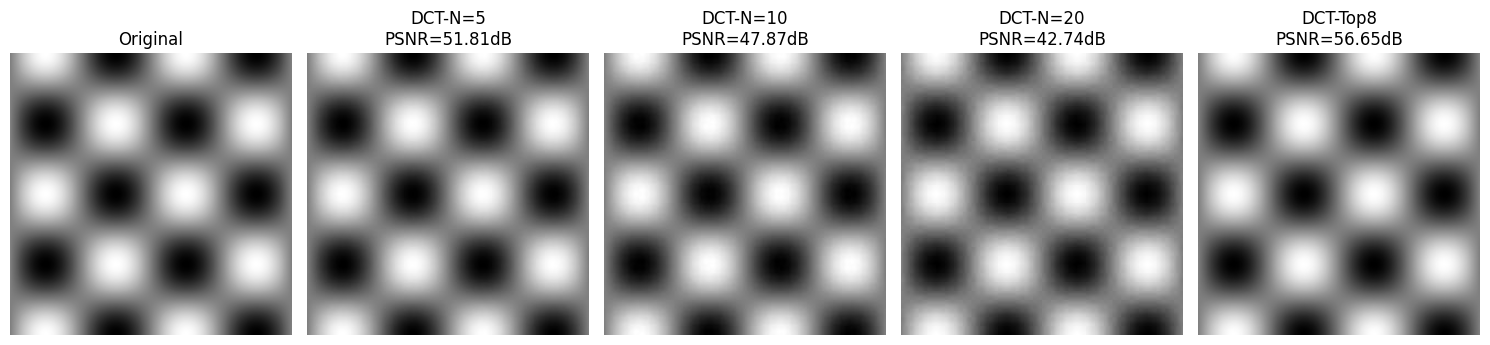


2. COMPRESIÓN CON FFT


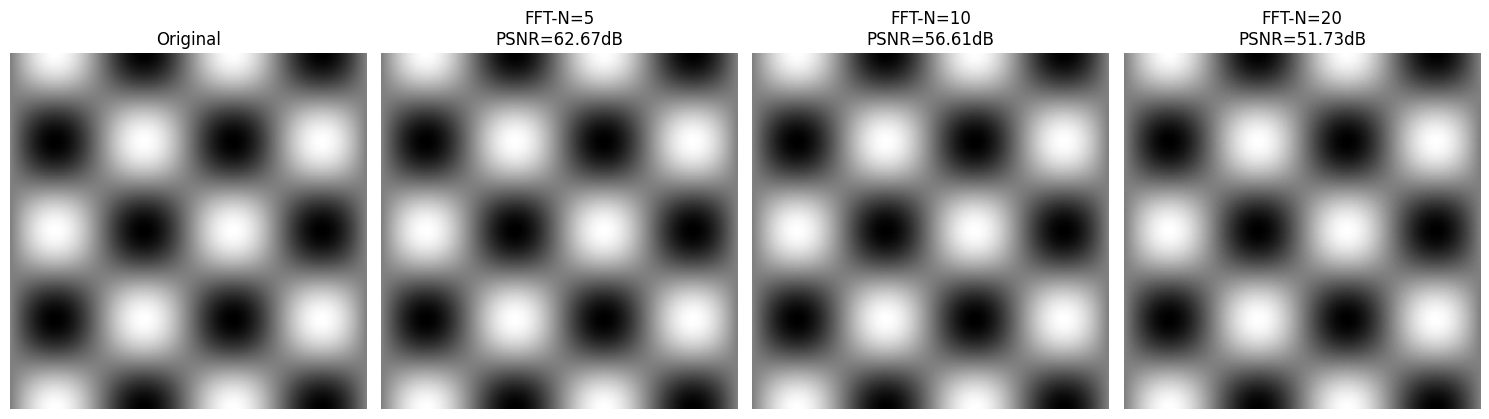


3. COMPRESIÓN DIRECTA (SIN TRANSFORMADA)


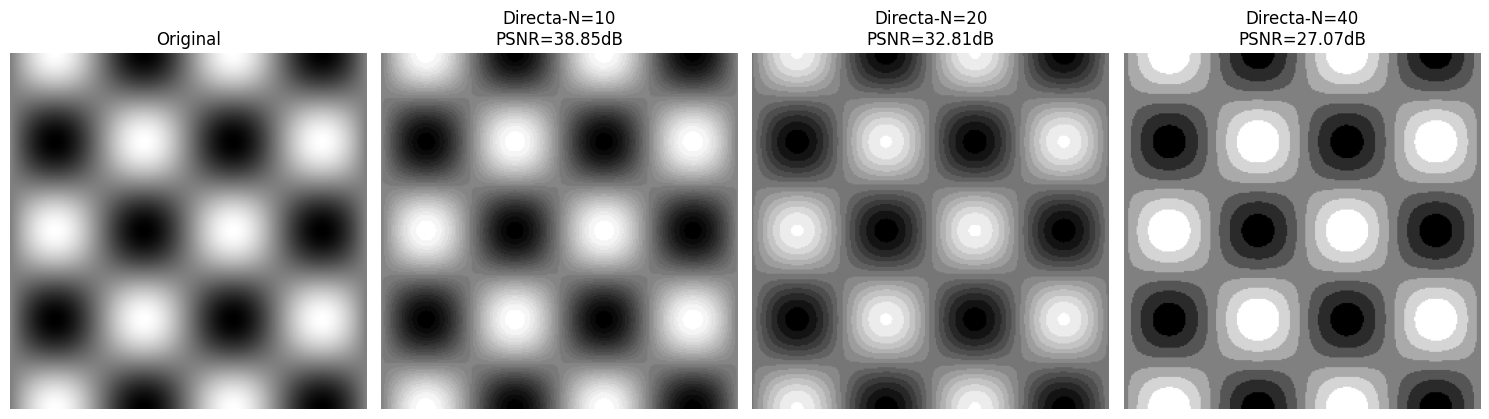


4. JPEG PARA IMÁGENES EN COLOR


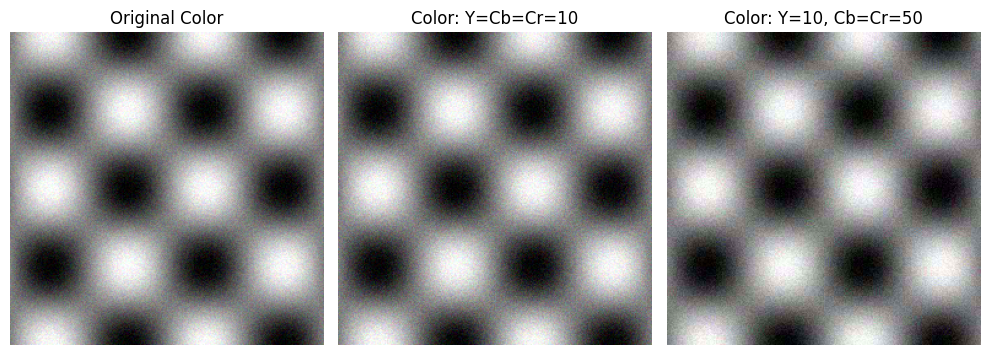


5. ANÁLISIS DE PREDICTORES Y ENTROPÍA
Entropía imagen original: 7.8920 bits/píxel
Entropía error predictor izquierdo: 3.6395 bits/píxel
Entropía error predictor superior: 3.6567 bits/píxel
Entropía error predictor promedio: 3.0911 bits/píxel

El mejor predictor es: Promedio (menor entropía)


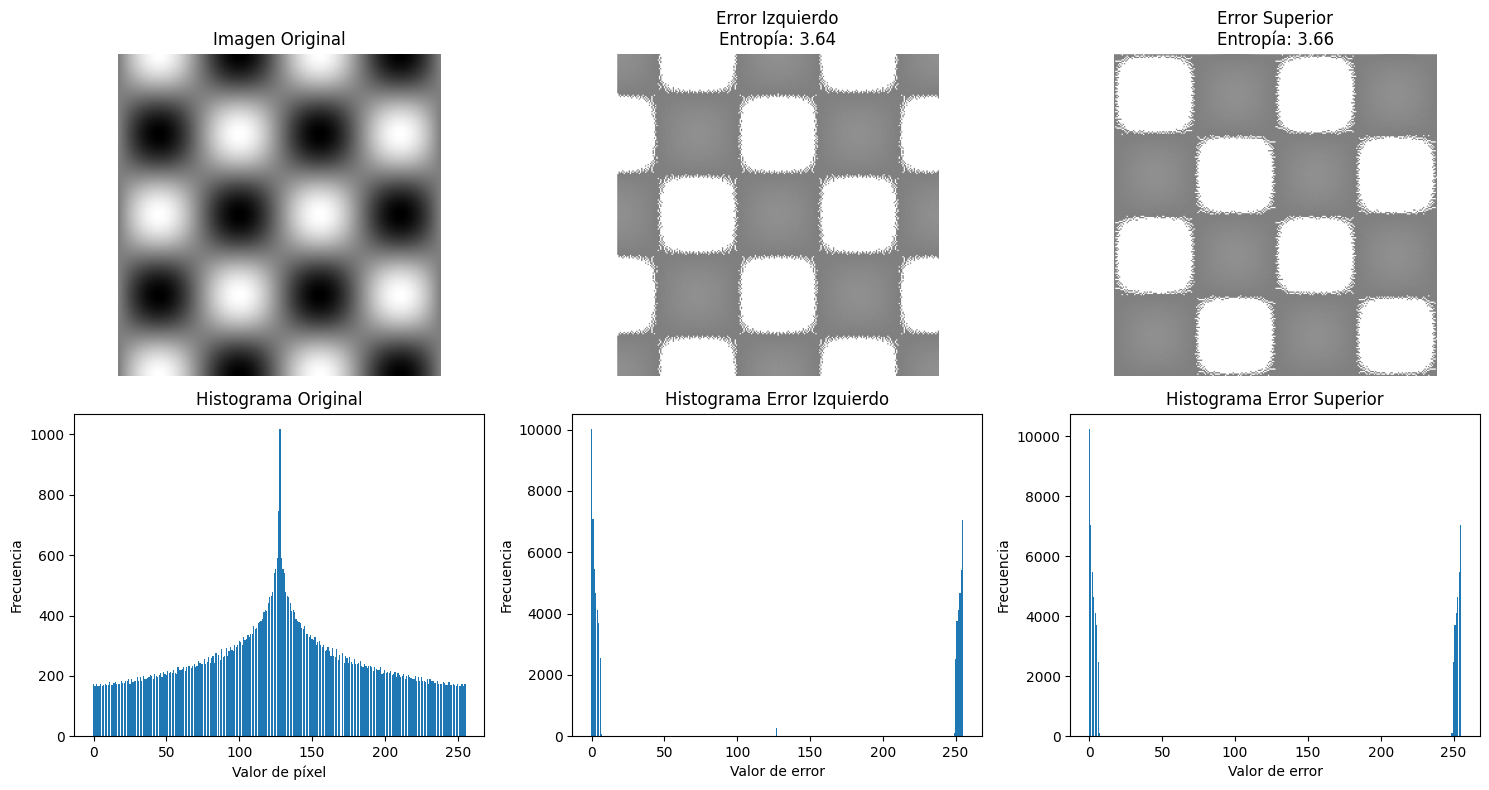


RESUMEN COMPARATIVO DE MÉTODOS DE COMPRESIÓN

Método			PSNR (dB)	Compresión Aprox.
--------------------------------------------------
DCT-N=5             	 51.81		9410.60:1
DCT-N=10            	 47.87		3796.13:1
DCT-Top8            	 56.65		28654.30:1
FFT-N=10            	 56.61		28390.53:1
Directa-N=20        	 32.81		118.53:1


In [12]:
# ============================================================================
# 7. EJEMPLO DE USO
# ============================================================================

def ejemplo_completo():
    """Ejecuta un ejemplo completo con todas las funcionalidades."""
    
    # Cargar una imagen de ejemplo (o crear una sintética)
    try:
        # Intentar cargar una imagen real
        from skimage import data
        imagen_gris = data.camera()
    except:
        # Crear una imagen sintética si no se puede cargar
        print("Creando imagen sintética para el ejemplo...")
        x = np.linspace(0, 4*np.pi, 256)
        y = np.linspace(0, 4*np.pi, 256)
        X, Y = np.meshgrid(x, y)
        imagen_gris = (127 + 127 * np.sin(X) * np.cos(Y)).astype(np.uint8)
    
    # Normalizar a [0, 255] si es necesario
    if imagen_gris.max() <= 1.0:
        imagen_gris = (imagen_gris * 255).astype(np.uint8)
    
    print(f"Tamaño de la imagen: {imagen_gris.shape}")
    print(f"Rango de valores: [{imagen_gris.min()}, {imagen_gris.max()}]")
    
    # ========================================================================
    # 1. JPEG CON DCT
    print("\n" + "="*60)
    print("1. JPEG CON DCT (Diferentes métodos)")
    print("="*60)
    
    # Probar diferentes métodos
    resultados_dct = []
    titulos_dct = []
    
    # Método de división por N
    for N in [5, 10, 20]:
        imagen_dct = jpeg_dct(imagen_gris, metodo='n', parametro=N)
        resultados_dct.append(imagen_dct)
        psnr = calcular_psnr(imagen_gris, imagen_dct)
        titulos_dct.append(f"DCT-N={N}\nPSNR={psnr:.2f}dB")
    
    # Método top-k
    imagen_dct_topk = jpeg_dct(imagen_gris, metodo='topk', parametro=8)
    resultados_dct.append(imagen_dct_topk)
    psnr = calcular_psnr(imagen_gris, imagen_dct_topk)
    titulos_dct.append(f"DCT-Top8\nPSNR={psnr:.2f}dB")
    
    visualizar_resultados(imagen_gris, resultados_dct, titulos_dct)
    
    # ========================================================================
    # 2. VERSIÓN CON FFT
    print("\n" + "="*60)
    print("2. COMPRESIÓN CON FFT")
    print("="*60)
    
    resultados_fft = []
    titulos_fft = []
    
    for N in [5, 10, 20]:
        imagen_fft = jpeg_fft(imagen_gris, metodo='n', parametro=N)
        resultados_fft.append(imagen_fft)
        psnr = calcular_psnr(imagen_gris, imagen_fft)
        titulos_fft.append(f"FFT-N={N}\nPSNR={psnr:.2f}dB")
    
    visualizar_resultados(imagen_gris, resultados_fft, titulos_fft)
    
    # ========================================================================
    # 3. COMPRESIÓN DIRECTA (SIN TRANSFORMADA)
    print("\n" + "="*60)
    print("3. COMPRESIÓN DIRECTA (SIN TRANSFORMADA)")
    print("="*60)
    
    resultados_directa = []
    titulos_directa = []
    
    for N in [10, 20, 40]:
        imagen_directa = compresion_directa(imagen_gris, metodo='n', parametro=N)
        resultados_directa.append(imagen_directa)
        psnr = calcular_psnr(imagen_gris, imagen_directa)
        titulos_directa.append(f"Directa-N={N}\nPSNR={psnr:.2f}dB")
    
    visualizar_resultados(imagen_gris, resultados_directa, titulos_directa)
    
    # ========================================================================
    # 4. JPEG PARA COLOR (si tenemos imagen de color)
    print("\n" + "="*60)
    print("4. JPEG PARA IMÁGENES EN COLOR")
    print("="*60)
    
    # Crear una imagen de color sintética si no hay una real
    if len(imagen_gris.shape) == 2:
        # Convertir a color repitiendo el canal de grises
        imagen_color = np.stack([imagen_gris, imagen_gris, imagen_gris], axis=2)
        # Modificar ligeramente los canales para que sean diferentes
        h, w = imagen_gris.shape
        for i in range(3):
            offset = np.random.randint(-20, 20, (h, w))
            imagen_color[:, :, i] = np.clip(imagen_color[:, :, i] + offset, 0, 255)
        imagen_color = imagen_color.astype(np.uint8)
    else:
        imagen_color = imagen_gris
    
    # Comprimir con diferentes niveles de compresión para crominancia
    resultados_color = []
    titulos_color = []
    
    # Calidad normal (misma para todos los canales)
    imagen_color_norm = jpeg_color(imagen_color, calidad_y=10, calidad_cb=10, calidad_cr=10)
    resultados_color.append(imagen_color_norm)
    titulos_color.append("Color: Y=Cb=Cr=10")
    
    # Calidad alta en Y, baja en crominancia
    imagen_color_alta_comp = jpeg_color(imagen_color, calidad_y=10, calidad_cb=50, calidad_cr=50)
    resultados_color.append(imagen_color_alta_comp)
    titulos_color.append("Color: Y=10, Cb=Cr=50")
    
    # Visualizar
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(imagen_color)
    plt.title('Original Color')
    plt.axis('off')
    
    for i, (imagen, titulo) in enumerate(zip(resultados_color, titulos_color)):
        plt.subplot(1, 3, i+2)
        plt.imshow(imagen)
        plt.title(titulo)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # 5. PREDICCIÓN Y ENTROPÍA
    print("\n" + "="*60)
    print("5. ANÁLISIS DE PREDICTORES Y ENTROPÍA")
    print("="*60)
    
    # Calcular errores de predicción
    error_izq, pred_izq = predictor_vecino_izquierdo(imagen_gris)
    error_sup, pred_sup = predictor_vecino_superior(imagen_gris)
    error_prom, pred_prom = predictor_promedio(imagen_gris)
    
    # Calcular histogramas
    hist_original = calcular_histograma(imagen_gris)
    hist_error_izq = calcular_histograma(error_izq)
    hist_error_sup = calcular_histograma(error_sup)
    hist_error_prom = calcular_histograma(error_prom)
    
    # Calcular entropías
    entropia_original = calcular_entropia(hist_original)
    entropia_izq = calcular_entropia(hist_error_izq)
    entropia_sup = calcular_entropia(hist_error_sup)
    entropia_prom = calcular_entropia(hist_error_prom)
    
    print(f"Entropía imagen original: {entropia_original:.4f} bits/píxel")
    print(f"Entropía error predictor izquierdo: {entropia_izq:.4f} bits/píxel")
    print(f"Entropía error predictor superior: {entropia_sup:.4f} bits/píxel")
    print(f"Entropía error predictor promedio: {entropia_prom:.4f} bits/píxel")
    
    # Determinar mejor predictor
    entropias = {
        'Vecino izquierdo': entropia_izq,
        'Vecino superior': entropia_sup,
        'Promedio': entropia_prom
    }
    
    mejor_predictor = min(entropias, key=entropias.get)
    print(f"\nEl mejor predictor es: {mejor_predictor} (menor entropía)")
    
    # Visualizar histogramas
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Imágenes originales y errores
    axes[0, 0].imshow(imagen_gris, cmap='gray')
    axes[0, 0].set_title('Imagen Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(error_izq, cmap='gray', vmin=-50, vmax=50)
    axes[0, 1].set_title(f'Error Izquierdo\nEntropía: {entropia_izq:.2f}')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(error_sup, cmap='gray', vmin=-50, vmax=50)
    axes[0, 2].set_title(f'Error Superior\nEntropía: {entropia_sup:.2f}')
    axes[0, 2].axis('off')
    
    # Histogramas
    axes[1, 0].bar(range(len(hist_original)), hist_original)
    axes[1, 0].set_title('Histograma Original')
    axes[1, 0].set_xlabel('Valor de píxel')
    axes[1, 0].set_ylabel('Frecuencia')
    
    axes[1, 1].bar(range(len(hist_error_izq)), hist_error_izq)
    axes[1, 1].set_title('Histograma Error Izquierdo')
    axes[1, 1].set_xlabel('Valor de error')
    axes[1, 1].set_ylabel('Frecuencia')
    
    axes[1, 2].bar(range(len(hist_error_sup)), hist_error_sup)
    axes[1, 2].set_title('Histograma Error Superior')
    axes[1, 2].set_xlabel('Valor de error')
    axes[1, 2].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # 6. RESUMEN COMPARATIVO
    print("\n" + "="*60)
    print("RESUMEN COMPARATIVO DE MÉTODOS DE COMPRESIÓN")
    print("="*60)
    
    # Crear tabla comparativa
    metodos = [
        ("DCT-N=5", jpeg_dct(imagen_gris, metodo='n', parametro=5)),
        ("DCT-N=10", jpeg_dct(imagen_gris, metodo='n', parametro=10)),
        ("DCT-Top8", jpeg_dct(imagen_gris, metodo='topk', parametro=8)),
        ("FFT-N=10", jpeg_fft(imagen_gris, metodo='n', parametro=10)),
        ("Directa-N=20", compresion_directa(imagen_gris, metodo='n', parametro=20))
    ]
    
    print("\nMétodo\t\t\tPSNR (dB)\tCompresión Aprox.")
    print("-" * 50)
    
    for nombre, imagen_comp in metodos:
        psnr = calcular_psnr(imagen_gris, imagen_comp)
        # Calcular tasa de compresión aproximada (basada en varianza de errores)
        error = imagen_gris - imagen_comp
        varianza_error = np.var(error)
        varianza_original = np.var(imagen_gris)
        compresion_aprox = varianza_original / max(varianza_error, 1e-10)
        
        print(f"{nombre:20s}\t{psnr:6.2f}\t\t{compresion_aprox:6.2f}:1")
    
    return imagen_gris, imagen_color

# Ejecutar el ejemplo
if __name__ == "__main__":
    imagen_gris, imagen_color = ejemplo_completo()